# Stats Notebook
1. Root-To-Tip Distance
  - All
  - Clade

---
# 1. SETUP

## Modules

In [67]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO
import seaborn as sns
import subprocess

from functions import *

## Paths

In [5]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chr
                 omosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [68]:
augur_dir   = os.path.join(results_dir, "augur/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))

metadata_path = augur_dir + "metadata.tsv"

# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Output
out_dir = os.path.join(results_dir, "figures/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [75]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

NO_DATA_CHAR = "NA"

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---
# 1. IMPORT

## Metadata

In [34]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
# Erase geometry column
metadata_df.drop(columns=["geometry"], inplace=True)

## Convert Dataframe to Geopandas

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,branch_support_char,node_type,branch_length,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor,mugration_country_confidence,mugration_province_confidence,mugration_branch_major_confidence,mugration_branch_minor_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,geometry_size,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err,root_rtt_dist,clade_rtt_dist,geometry
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,NA,terminal,6.334000e-06,100.0,-29.000,NA,NA,United States of America,Colorado,1.ORI,1.ORI1,1.00,1.00,1.00,1.00,39.783730,-100.445882,38.725178,-105.607716,1.0,1992,1992,0.000072,28.00000,0.000072,#ff0000,8352.42496,28.00000,1992.0,0.0,0.0,0.000072,6.380000e-06,POINT (-105.60772 38.72518)
GCA_009670865.1_ASM967086v1_genomic,42012,1971.0,-50,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722853,KEEP: Assembly Modern Placement,0,Asia,1971,50,0,42.4805,85.4633,NA,terminal,1.078700e-05,100.0,-50.000,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.00,1.00,1.00,1.00,35.000074,104.999927,42.480495,85.463346,4.0,1971,1971,0.000053,7.00000,0.000053,#4062fa,8331.42500,7.00000,1971.0,0.0,0.0,0.000053,1.078700e-05,POINT (85.46335 42.48050)
GCA_008630435.1_ASM863043v1_genomic,C-719,1996.0,-25,Russia,Karachay-Cherkessia,64.6863,97.7453,43.7368,41.7268,Medievalis,2.MED,2.MED0,SAMN12721146,KEEP: Assembly Modern Placement,2,Europe,1996,25,0,43.7368,41.7268,NA,terminal,2.417700e-05,100.0,-25.000,NA,NA,Russia,Karachay-Cherkessia,2.MED,2.MED0,1.00,1.00,1.00,1.00,64.686314,97.745306,43.736833,41.726799,1.0,1996,1996,0.000086,15.00000,0.000086,#80ffb4,8356.42610,15.00000,1996.0,0.0,0.0,0.000086,2.952100e-05,POINT (41.72680 43.73683)
GCA_000169635.1_ASM16963v1_genomic,MG05-1020,2005.0,-16,Madagascar,NA,-18.925,46.4416,NA,NA,Orientalis,1.ORI,1.ORI3,SAMN02404403,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,1,Africa,2005,16,0,-18.925,46.4416,NA,terminal,4.927000e-06,100.0,-16.000,NA,NA,Madagascar,Yunnan,1.ORI,1.ORI3,1.00,0.21,1.00,1.00,-18.924960,46.441642,25.000000,102.000000,2.0,2005,2005,0.000071,26.00000,0.000071,#ff0000,8365.42496,26.00000,2005.0,0.0,0.0,0.000071,4.950000e-06,POINT (102.00000 25.00000)
GCA_000170275.1_ASM17027v1_genomic,F1991016,1991.0,-30,China,Yunnan,35.0001,105,25,102,Orientalis,1.ORI,1.ORI2,SAMN02404399,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,1,Asia,1991,30,0,25,102,NA,terminal,5.396000e-06,100.0,-30.000,NA,NA,China,Yunnan,1.ORI,1.ORI2,1.00,1.00,1.00,1.00,35.000074,104.999927,25.000000,102.000000,2.0,1991,1991,0.000071,25.00000,0.000071,#ff0000,8351.42496,25.00000,1991.0,0.0,0.0,0.000071,5.396000e-06,POINT (102.00000 25.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE22,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,7.030000e-07,0.0,-697.117,"{138.712,50502.4}","{-50502.4,-138.712}",China,Gansu,1.IN,1.IN2,0.96,0.36,1.00,0.42,35.000074,104.999927,38.000000,102.000000,1.0,NA,NA,0.000059,23.96875,0.000059,#ff6232,7684.30810,23.96875,1324.0,49805.0,559.0,0.000059,7.030000e-07,POINT (102.00000 38.00000)
NODE23,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,

<GeoAxesSubplot:>

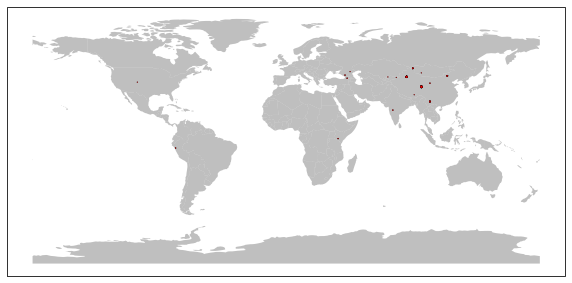

In [78]:
geometry = []
# Erase geometry column
for rec in metadata_df.iterrows():
    sample = rec[0]
    lat = rec[1]["mugration_province_lat"]
    lon = rec[1]["mugration_province_lon"]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)
    
metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

display(metadata_gdf)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)

---
# 2. RTT (Root-To-Tip Regression)

## All

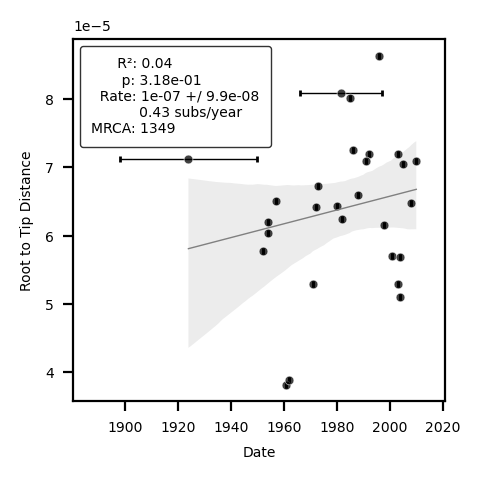

In [93]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

df = metadata_gdf[(metadata_gdf["node_type"] == "terminal") & (metadata_gdf["date_mean"] != NO_DATA_CHAR)]
reg_x = "date_mean"
reg_y = "root_rtt_dist"
reg_err = "date_err"

# -----------------------
# Regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
r2 = r_value * r_value    
y_intercept = CURRENT_YEAR - (0 - intercept)/slope
p_sig = ""
p_thresh = 0.05    
if p_value < p_thresh:
    p_sig = "*"

sub_per_year = SEQ_LEN * slope
year_per_sub = 1 / sub_per_year
y_intercept_calendar = CURRENT_YEAR - y_intercept

sns.regplot(
    ax=ax,
    data=df, 
    x=list(df[reg_x]), 
    y=list(df[reg_y]), 
    ci=95,
    scatter_kws={"s": 0},
    line_kws={"linewidth" : 0.5},
    color="grey",
    #color=df["branch_major_color"][0],
    label=(
    "      R²: {}".format(round(r2,2))
    + "\n       p: {:.2e}{}".format(p_value, p_sig)
    + "\n  Rate: {:.2} +/ {:.2}".format(slope, std_err)  
    + "\n           {} subs/year".format(round(sub_per_year, 2))
    + "\nMRCA: {}".format(round(y_intercept_calendar))                
    )
)


ax.errorbar(
    data=df, 
    x=reg_x, 
    y=reg_y, 
    xerr=reg_err,
    yerr=None,
    ls='none',
    c = "black",  
    capsize=1,
    label=None,
    zorder=1,
    lw=0.5,
    )  

sns.scatterplot(
    ax=ax,
    data=df, 
    x=reg_x, 
    y=reg_y, 
    s=10,    
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
) 


# Set xlimits
xlim = ax.get_xlim()
x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]

if new_xlim[1] > CURRENT_YEAR:
    new_xlim = [new_xlim[0], CURRENT_YEAR]
ax.set_xlim(new_xlim)
    
ax.set_ylabel("Root to Tip Distance")
ax.set_xlabel("Date")    
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "rtt_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Clades

Branch: 0.PRE
Branch: 0.ANT4
Branch: 0.PE
Branch: 0.ANT
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


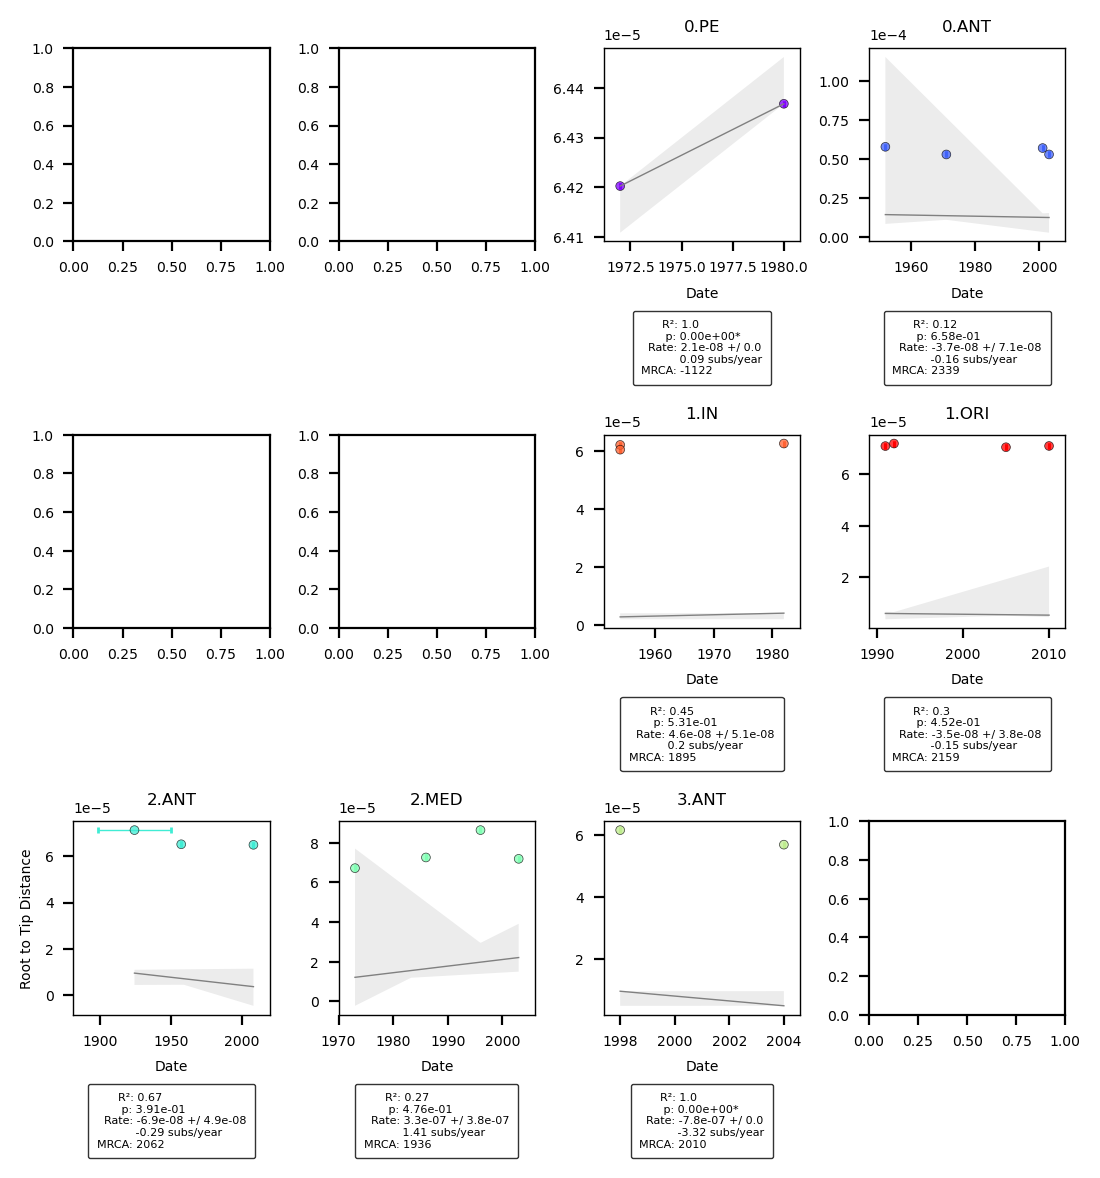

In [94]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "clade_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]  
    # If no records for this branch, continue
    if len(df) < 2: 
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"

    sub_per_year = SEQ_LEN * slope
    year_per_sub = 1 / sub_per_year    
    y_intercept_calendar = CURRENT_YEAR - y_intercept

    sns.regplot(
        ax=ax,
        data=df, 
        x=list(df[reg_x]), 
        y=list(df[reg_y]), 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "      R²: {}".format(round(r2,2))
        + "\n       p: {:.2e}{}".format(p_value, p_sig)
        + "\n  Rate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n           {} subs/year".format(round(sub_per_year, 2))
        + "\nMRCA: {}".format(round(y_intercept_calendar))                
        )
    )

    
    ax.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )    
    
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
    
out_path = os.path.join(out_dir, "rtt_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 3. IBD (Isolation By Distance)

## All